### Create Train and Test Datasets
---

This notebook loads a dataset from synthetic neural activity signals then splits it equal halves train and test datasets.
 
We then plot sequences from the two halves to see if they are organized correctly for next-timestep sequence-to-sequence prediction.

#### Libraries
---

In [1]:
# %load_ext cudf.pandas
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import NEURONS_302, VALID_DATASETS
from data._utils import create_combined_dataset, split_combined_dataset

# Silence warnings
warnings.filterwarnings("ignore", category=FutureWarning)

CUDA device found.


#### Create datasets
---

In [2]:
%%time
# Create a single combined dataset from the one of the 8 experimental datasets of your choice
experimental_dataset = "Leifer2023"
assert experimental_dataset in VALID_DATASETS, f"Invalid dataset: {experimental_dataset}"
datasets = dict(Leifer2023=1)  # a real worm neural dataset (1 worm)
combined_dataset, dataset_info = create_combined_dataset(
    datasets, num_named_neurons=None
)
num_worms = len(combined_dataset)

# Split the datsaet into train and validation halves
num_train_samples = num_val_samples = num_samples = 2
reverse = use_residual = False
smooth_data = True
seq_len = 500
train_dataset, val_dataset, timestep_info = split_combined_dataset(
    combined_dataset,
    num_train_samples,
    num_val_samples,
    seq_len,
    reverse,
    use_residual,
    smooth_data,
)

CPU times: user 955 ms, sys: 2.06 s, total: 3.01 s
Wall time: 3.4 s


#### Sample train and test sequences
---

In [3]:
%%time
# NOTE: The last train sample comes right before the first test sample.

# Get the sample from the train dataset
X_train, Y_train, mask_train, meta_train = train_dataset[-1]
time_train = meta_train["time_vec"]
print(
    f"\nX:{X_train.shape}\nY:{Y_train.shape}\nmask:{mask_train.shape}\ntime:{time_train.shape}\n"
)

# Get the sample from the validation dataset
X_test, Y_test, mask_test, meta_test = val_dataset[0]
time_test = meta_test["time_vec"]
print(
    f"\nX:{X_test.shape}\nY:{Y_test.shape}\nmask:{mask_test.shape}\ntime:{time_test.shape}\n"
)


X:torch.Size([500, 302])
Y:torch.Size([500, 302])
mask:torch.Size([302])
time:torch.Size([500])


X:torch.Size([500, 302])
Y:torch.Size([500, 302])
mask:torch.Size([302])
time:torch.Size([500])

CPU times: user 92 µs, sys: 48 µs, total: 140 µs
Wall time: 134 µs


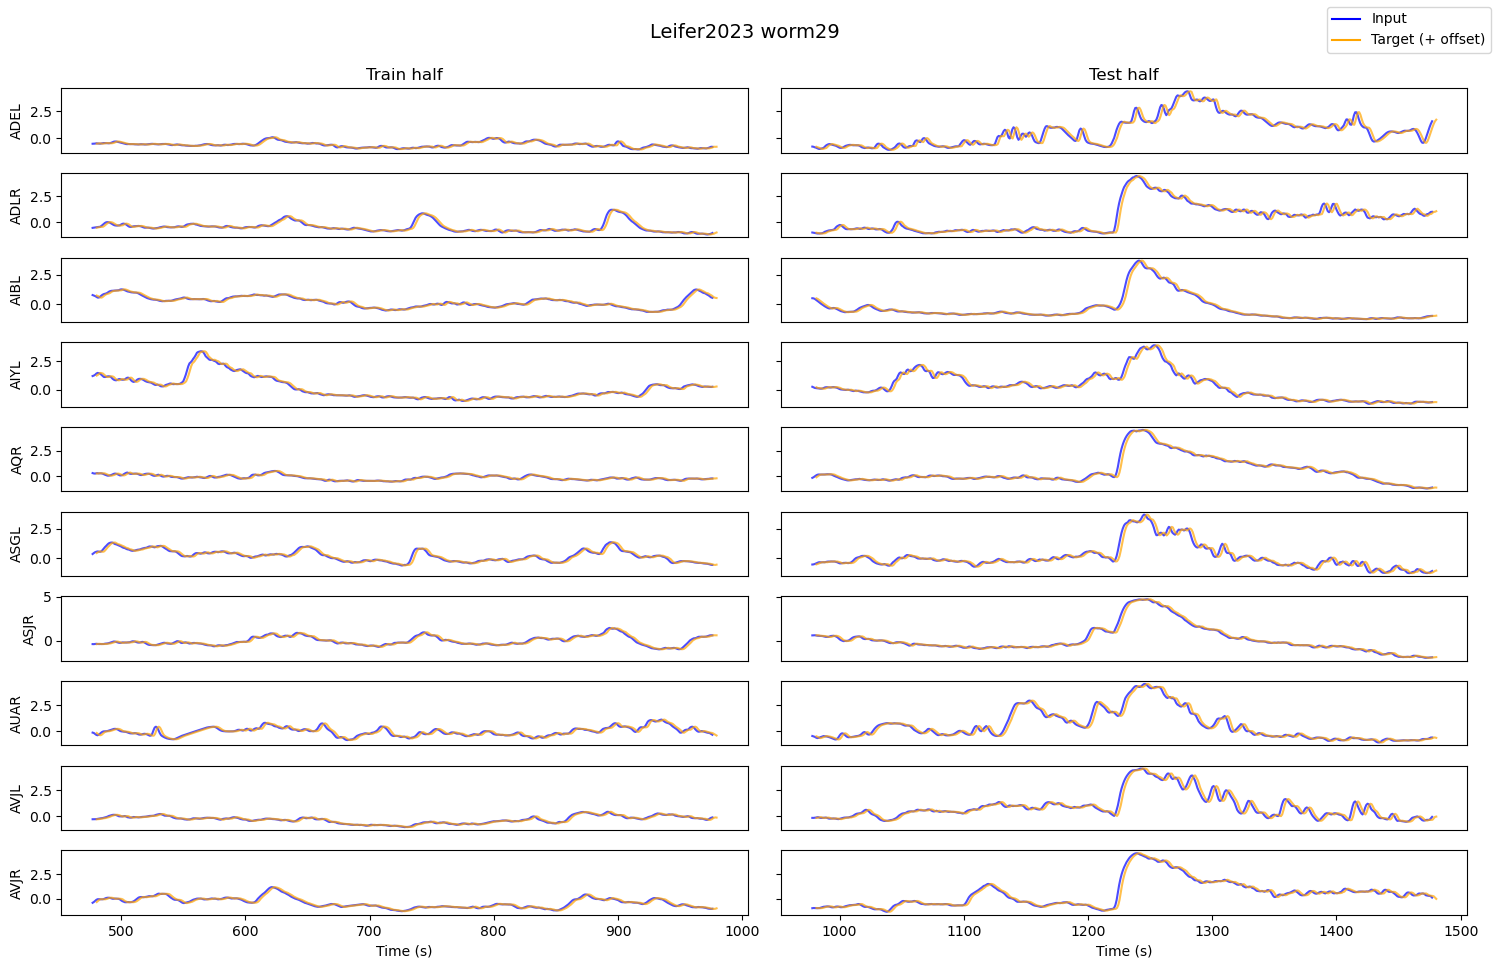

CPU times: user 2.07 s, sys: 202 ms, total: 2.27 s
Wall time: 2.05 s


In [4]:
%%time
# Set up the matplotlib figure for two columns of subplots
max_neurons_to_plot = 10
num_neurons_train = mask_train.sum().item()
num_neurons_test = mask_test.sum().item()
num_neurons = min(max_neurons_to_plot, num_neurons_train, num_neurons_test)
fig, axes = plt.subplots(num_neurons, 2, figsize=(15, 10), sharey="row")

# Plot data for each half
for col, phase in enumerate(["train", "test"]):
    # Convert the data to NumPy arrays if they are not already
    time = eval(f"time_{phase}.numpy()")
    X = eval(f"X_{phase}.numpy()")
    Y = eval(f"Y_{phase}.numpy()")
    mask = eval(f"mask_{phase}.numpy()")
    worm_dataset = eval(f"meta_{phase}['worm_dataset']")
    wormID = eval(f"meta_{phase}['wormID']")

    # Set offsets for the target data
    y_offset_step = 5
    x_offset = len(time) / 100

    # Get the indices of the neurons to plot
    neurons_to_plot = np.where(mask)[0][:num_neurons]

    data_fragments = []

    for i, neuron_idx in enumerate(neurons_to_plot):
        neuron_label = NEURONS_302[neuron_idx]

        # Collect input data
        input_df = pd.DataFrame(
            {
                "Time": time,
                "Value": X[:, neuron_idx],
                "Type": "Input",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(input_df)

        # Collect target data with time offset
        target_df = pd.DataFrame(
            {
                "Time": time
                + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y[:, neuron_idx],
                "Type": "Target (+ offset)",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(target_df)

    # Concatenate all fragments to create the full DataFrame
    df = pd.concat(data_fragments, ignore_index=True)

    # Plot the lines
    for i, neuron_label in enumerate(neurons_to_plot):
        sns.lineplot(
            data=df[df["Neuron"] == NEURONS_302[neuron_label]],
            x="Time",
            y="Value",
            hue="Type",
            ax=axes[i, col],
            palette=["blue", "orange"],
            alpha=0.7,
            errorbar=None,
        )
        axes[i, col].set_ylabel(NEURONS_302[neuron_label])
        axes[i, col].get_legend().remove()

        # Set the x-axis label to empty
        axes[i, col].set_xlabel("")

        # Hide x-axis labels and ticks for all but the last row
        if i < num_neurons - 1:
            axes[i, col].set_xticklabels([])
            axes[i, col].set_xticks([])
        else:
            axes[i, col].set_xlabel("Time (s)")

        # Set title only for the first row of each column
        if i == 0:
            axes[i, col].set_title(f"{phase.capitalize()} half")
        else:
            axes[i, col].set_title("")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display name of dataset and worm as suptitle
fig.suptitle(f"{worm_dataset} {wormID}", fontsize=14)

# Display the legend outside the rightmost plot
handles, labels = axes[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.show()

### Train a simple linear regression model

In [35]:
%%time
from torch import no_grad
from torch.optim import Adam
from torch.utils.data import DataLoader
from utils import VALID_DATASETS, DEVICE
from models._utils import LinearRegression
from train._utils import compute_loss_vectorized
from data._utils import create_combined_dataset, split_combined_dataset

# Create a single combined dataset from all the worms
datasets = dict(
    (dataset, "all") for dataset in VALID_DATASETS
)  # a real worm neural dataset (all worms)
combined_dataset, dataset_info = create_combined_dataset(
    datasets, num_named_neurons=None
)
num_worms = len(combined_dataset)

# Split the datsaet into train and validation halves
num_train_samples = 32
num_val_samples = 16
reverse = use_residual = False
smooth_data = True
seq_len = 100
train_dataset, val_dataset, timestep_info = split_combined_dataset(
    combined_dataset,
    num_train_samples,
    num_val_samples,
    seq_len,
    reverse,
    use_residual,
    smooth_data,
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

# Initialize the model and optimizer
model = LinearRegression(302)
optimizer = Adam(model.parameters(), lr=0.001)

CPU times: user 6.33 s, sys: 8.53 s, total: 14.9 s
Wall time: 23 s


In [36]:
%%time
# Create a training pipeline
model.to(DEVICE)
for epoch in range(0):  # train for 2 epochs
    # Training loop
    model.train()  # set model to training mode
    avg_train_loss = 0.0
    for batch in train_loader:
        X, Y, mask, meta = batch  # get input and target data
        optimizer.zero_grad()  # zero gradients
        Y_pred = model(X.to(DEVICE), mask.to(DEVICE))  # forward pass
        loss = compute_loss_vectorized(
            model.loss_fn(), Y_pred, Y.to(DEVICE), mask.to(DEVICE)
        )  # calculate loss
        loss.backward()  # backward pass
        optimizer.step()  # update model weights
        avg_train_loss += loss.item() / len(train_loader)
        # break
    print(f"Train loss: {avg_train_loss}")

    # Validation loop
    model.eval()  # set model to evaluation mode
    with no_grad():
        avg_val_loss = 0.0
        for batch in val_loader:
            X, Y, mask, meta = batch
            Y_pred = model(X.to(DEVICE), mask.to(DEVICE))
            loss = compute_loss_vectorized(
                model.loss_fn(), Y_pred, Y.to(DEVICE), mask.to(DEVICE)
            )
            avg_val_loss += loss.item() / len(val_loader)
            # break
        print(f"\tVal loss: {avg_val_loss}")

Train loss: 0.5475103525628505
	Val loss: 0.4287075198871987
Train loss: 0.3845009516242524
	Val loss: 0.3503001806601672
CPU times: user 4.5 s, sys: 88.7 ms, total: 4.59 s
Wall time: 4.67 s


In [40]:
%%time
# Get inputs and targets from dataloaders and outputs from model
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

X_train, Y_train, mask_train, meta_train = next(iter(train_loader))
time_train = meta_train["time_vec"]
Y_pred_train = model(X_train.to(DEVICE), mask_train.to(DEVICE))
print(
    f"\nX:{X_train.shape}\nY:{Y_train.shape}\nmask:{mask_train.shape}\ntime:{time_train.shape}\n"
)

X_test, Y_test, mask_test, meta_test = next(iter(val_loader))
Y_pred_test = model(X_test.to(DEVICE), mask_test.to(DEVICE))
time_test = meta_test["time_vec"]
print(
    f"\nX:{X_test.shape}\nY:{Y_test.shape}\nmask:{mask_test.shape}\ntime:{time_test.shape}\n"
)

RuntimeError: The expanded size of the tensor (100) must match the existing size (302) at non-singleton dimension 0.  Target sizes: [100, 302].  Tensor sizes: [302, 1]

### Visualize inputs against model predictions

In [ ]:
def plot_train_test_samples(
    X_train, X_test, Y_train, Y_test, maxk_train, mask_test, model=None
):
    return None

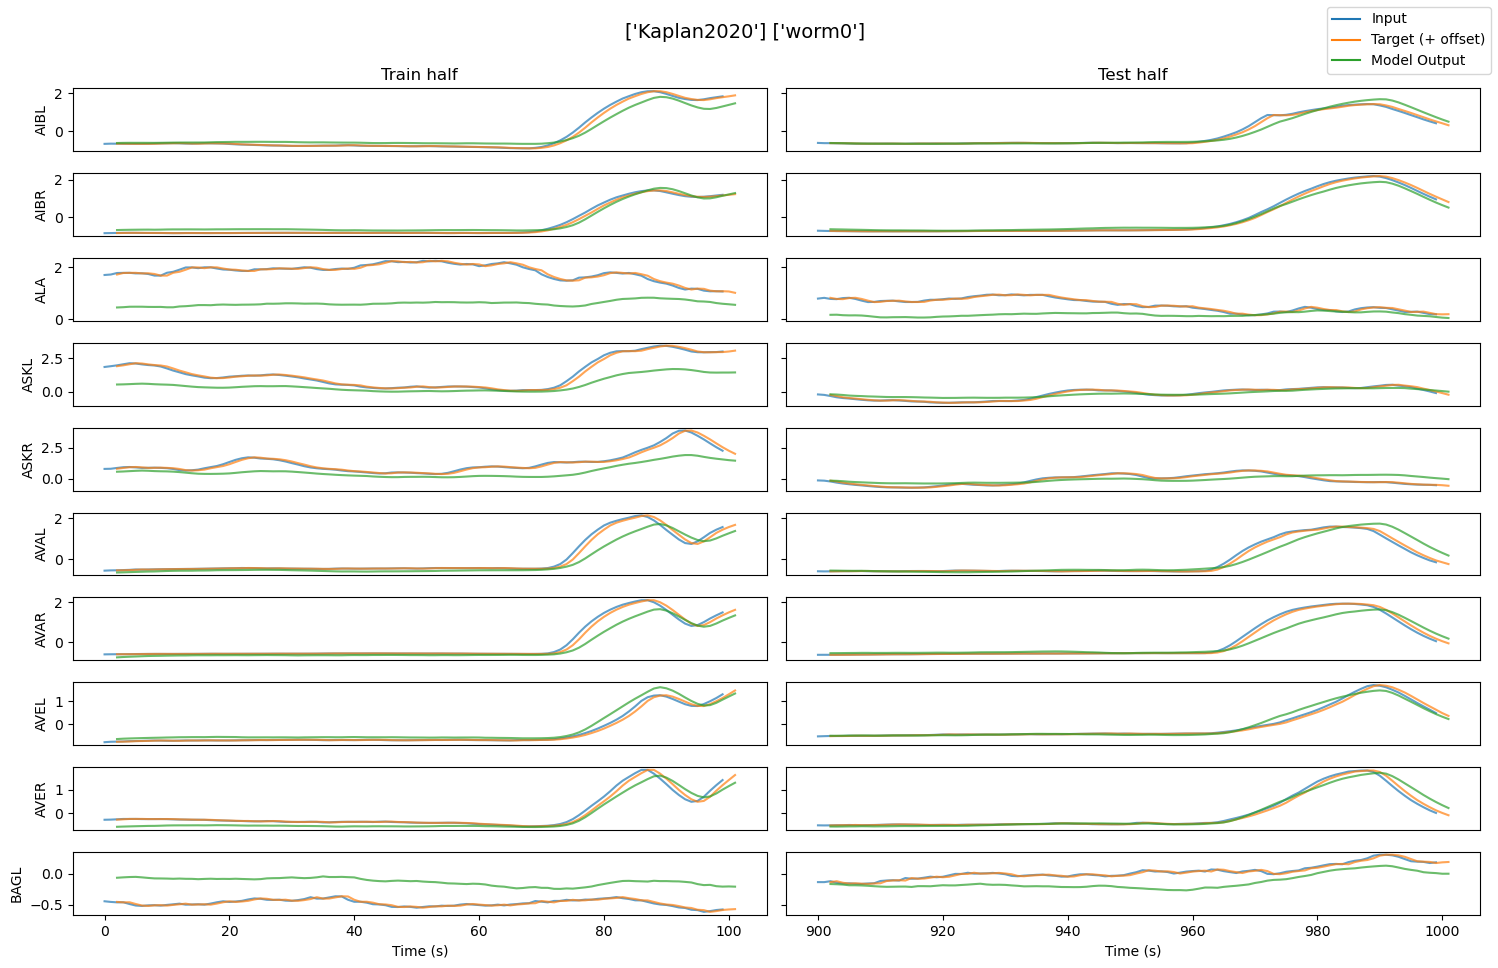

CPU times: user 2.51 s, sys: 227 ms, total: 2.74 s
Wall time: 2.54 s


In [39]:
%%time
# Set up the matplotlib figure for two columns of subplots
max_neurons_to_plot = 10
num_neurons_train = mask_train.sum().item()
num_neurons_test = mask_test.sum().item()
num_neurons = min(max_neurons_to_plot, num_neurons_train, num_neurons_test)
fig, axes = plt.subplots(num_neurons, 2, figsize=(15, 10), sharey="row")

# Plot data for each half
for col, phase in enumerate(["train", "test"]):
    # Convert the data to NumPy arrays if they are not already
    time = eval(f"time_{phase}.squeeze().cpu().numpy()")
    X = eval(f"X_{phase}.detach().squeeze().cpu().numpy()") # input
    Y = eval(f"Y_{phase}.squeeze().cpu().numpy()") # target
    Y_pred = eval(f"Y_pred_{phase}.detach().squeeze().cpu().numpy()") # output
    mask = eval(f"mask_{phase}.detach().squeeze().cpu().numpy()")
    worm_dataset = eval(f"meta_{phase}['worm_dataset']")
    wormID = eval(f"meta_{phase}['wormID']")

    # Set offsets for the target data
    y_offset_step = 5
    x_offset = len(time) / 50

    # Get the indices of the neurons to plot
    neurons_to_plot = np.where(mask)[0][:num_neurons]

    data_fragments = []

    for i, neuron_idx in enumerate(neurons_to_plot):
        neuron_label = NEURONS_302[neuron_idx]

        # Collect input data
        input_df = pd.DataFrame(
            {
                "Time": time,
                "Value": X[:, neuron_idx],
                "Type": "Input",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(input_df)

        # Collect target data with time offset
        target_df = pd.DataFrame(
            {
                "Time": time
                + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y[:, neuron_idx],
                "Type": "Target (+ offset)",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(target_df)

        # Collect output data with time offset
        output_df = pd.DataFrame(
            {
                "Time": time
                + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y_pred[:, neuron_idx],
                "Type": "Model Output",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(output_df)

    # Concatenate all fragments to create the full DataFrame
    df = pd.concat(data_fragments, ignore_index=True)

    # Plot the lines
    for i, neuron_label in enumerate(neurons_to_plot):
        sns.lineplot(
            data=df[df["Neuron"] == NEURONS_302[neuron_label]],
            x="Time",
            y="Value",
            hue="Type",
            ax=axes[i, col],
            palette="tab10",
            alpha=0.7,
            errorbar=None,
        )
        axes[i, col].set_ylabel(NEURONS_302[neuron_label])
        axes[i, col].get_legend().remove()

        # Set the x-axis label to empty
        axes[i, col].set_xlabel("")

        # Hide x-axis labels and ticks for all but the last row
        if i < num_neurons - 1:
            axes[i, col].set_xticklabels([])
            axes[i, col].set_xticks([])
        else:
            axes[i, col].set_xlabel("Time (s)")

        # Set title only for the first row of each column
        if i == 0:
            axes[i, col].set_title(f"{phase.capitalize()} half")
        else:
            axes[i, col].set_title("")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display name of dataset and worm as suptitle
fig.suptitle(f"{worm_dataset} {wormID}", fontsize=14)

# Display the legend outside the rightmost plot
handles, labels = axes[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.show()

#### Before training
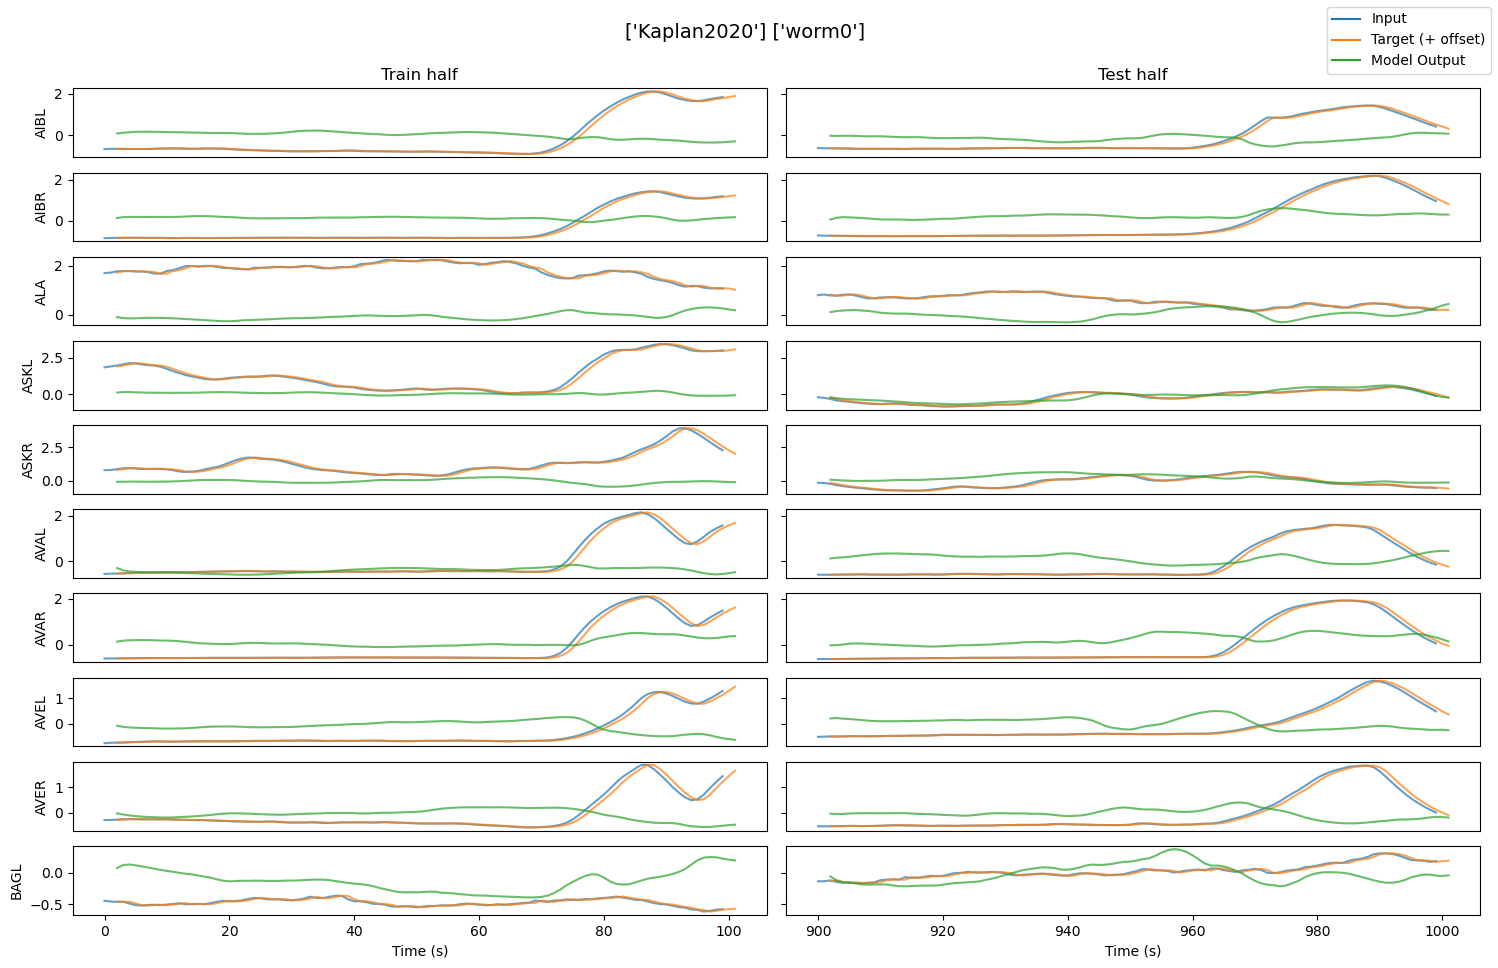

#### After training
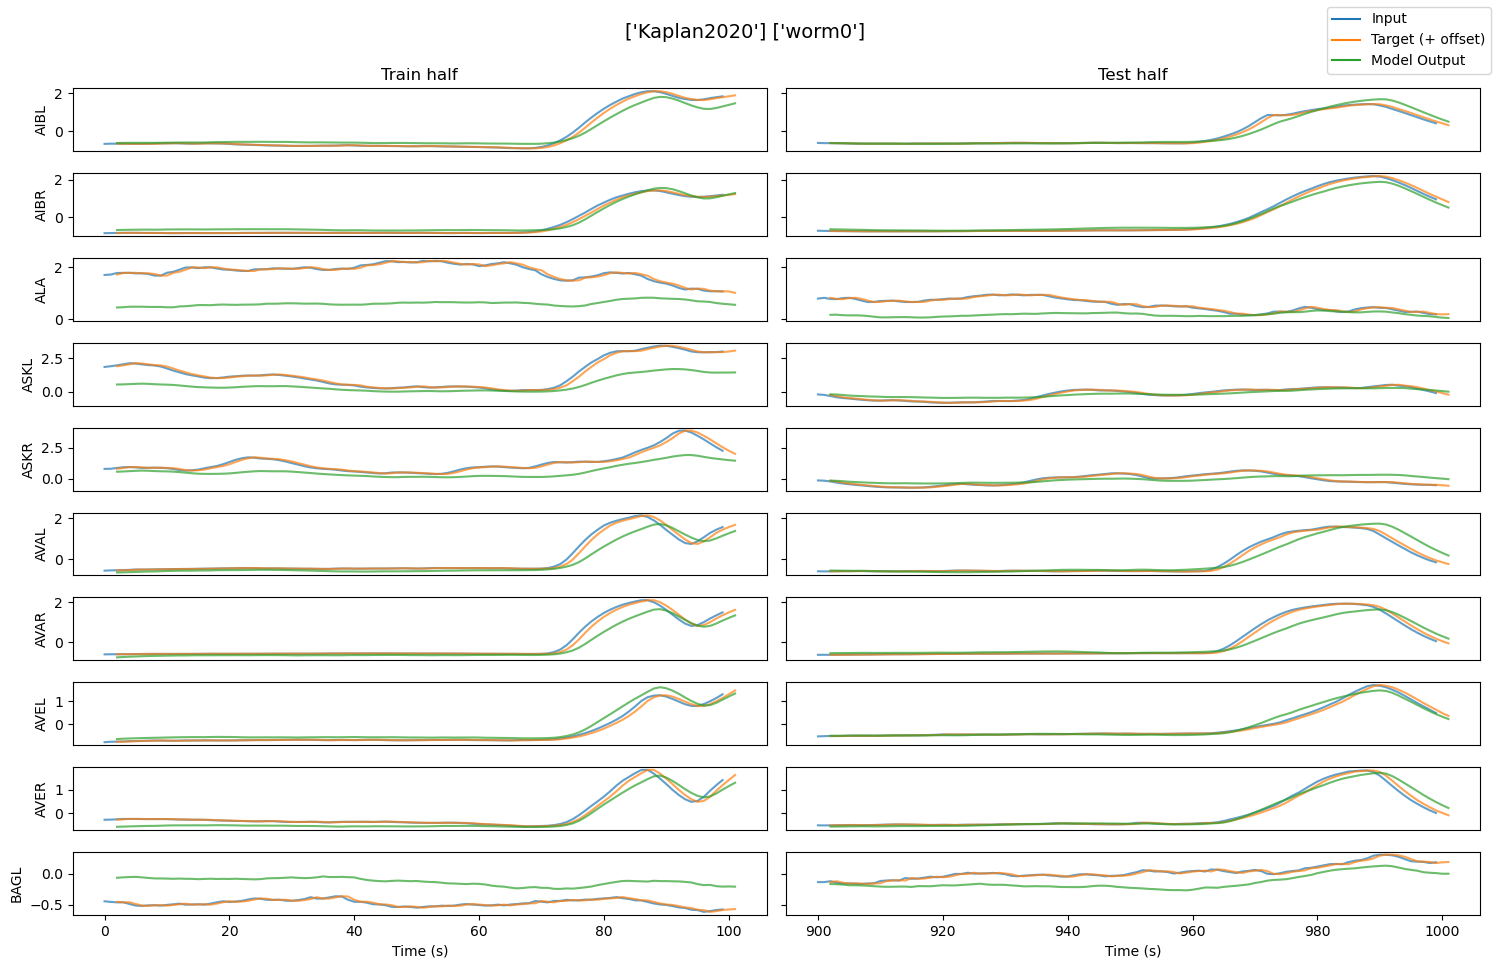